# Virtual ADC example
---

Welcome to the Virtual ADC example of X-HEEP's FEMU! 
This notebook will demonstrate how to: 
1. Take a signal from a `.txt` file and convert it to a `Timeseries` variable.
2. Load a pair of signals from a `Timeseries` variable and feed it to the virtual ADC. 
3. Interact with the X-HEEP's C code from this notebook through a `definitions.h` file.  
4. Load the bitstream describing X-HEEP into the FPGA's Programmable Logic
5. Launch an application on X-HEEP that receives the virtual ADC's input through SPI and outputs the result of applying some processing through the UART.
6. Plot the results obtained from X-HEEP's execution. 
7. Obtain performance measurements from the execution, plot them to spot bottlenecks and compare them to application requirements.

---


## Initialization

First some key paths are set and added to the system path. 

In [ ]:
BASELINE_PATH   = '/home/xilinx/x-heep-femu-sdk/sw/'                        # Path to the software side of the FEMU
SDK_PATH        = BASELINE_PATH + "arm/sdk/"                                # PAth to the SDK
APP_PATH        = BASELINE_PATH + 'riscv/apps/vadc_example/'                # Path to the .c file of the ADC-emu application
NB_PATH         = BASELINE_PATH + 'arm/jupyter_notebooks/vadc_example/'     # Path to this notebook
ADC_EMU_PATH    = SDK_PATH      + 'adc-emu/src'                             # Path to the API of the ADC emulator

# Add some key paths to the system path
import sys
sys.path.append(SDK_PATH)
sys.path.append(ADC_EMU_PATH )

# Fixed information on where input and output data should be stored, and in which format
PATH_IN         = 'in/'
PATH_OUT        = 'out/'
EXTENSION_IN    = '.txt'
ADC_BIN_NAME    = 'adc_in'
DATA_FILE_NAME  = APP_PATH + ADC_BIN_NAME + ".bin"

Include the SDK modules you want to use.

> The code at the top will guarantee that the modules are reloaded when using Jupyter Notebooks on Visual Studio Code. 

In [2]:
#!/usr/bin/env python3
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from pynq import x_heep
from perf_counters import *
from x_heep_code import *
from timeseries import *
from processes import *
from adc_emu import *
from vadc import *

## Creating an emulated ADC and feeding signals to it

Signals can be found in different formats and flavours. In order to standardize the format in which we feed information to the virtual-ADC (vADC) we will transform the input signal to a `Timeseries` variable. This `Timeseries` can be exported to a `.bin` file for the vADC. Additionally, one or more `Timeseries` can be fed into the `ADC-emulator` (ADC-emu), which will take the ADC parameters and pre-process the input signal to emulate a signal acquired by such an ADC. The output of the ADC-emu can then be converted to a `.bin` file to be read by the vADC. 

### Read the input file 

We will use a multimodal dataset containing data from different biosignals. This file is a `.txt` from which we will extract some channels and feed them a multi-channel ADC-emu to obtain a pre-processed signal that can be fed to the vADC. 

The input file has the following format:
```
Time,FP1,FP2,C3,C4,O1,O2,SPR1,SPR2,ECG1,ECG2
0.005,86.512,-61.877,73.345,-196.646,120.742,-10.405,-121.088,-6.189,1.378,-24.799
0.010,54.116,-194.703,32.428,-161.863,129.175,65.907,-121.581,-27.004,22.375,-29.840
```


> Data obtained from [Aminosharieh et al., "Drivers' Mental Engagement Analysis Using Multi-Sensor Fusion Approaches Based on Deep Convolutional Neural Networks", 2023](https://www.mdpi.com/1424-8220/23/17/7346).


The execution of this cell should take ~30s

In [3]:
# Read the file, strip it from special characters and split it into elements
with open( NB_PATH + PATH_IN + 'multimodal/S1_ADAS1.txt') as f: y = f.readlines()
titles = y[0].strip().split(',')                                        # Extract the title of each channel
data = np.asarray([[float(f) for f in l.split(',')] for l in y[1:]])    # Extract the cleaned values (ignoring the titles)

channels = []
for i in range(len(titles)): channels.append([row[i] for row in data])  # Get the values for each channel

### Clean the signal to be converted to a Timeseries

`Timeseries` variables are a pair of vectors containing timestamps and data values (not necessarily sampled at a fixed rate). We will manipulate the input signal to extract these two pairs so we can later feed them to the ADC-emu. 

In [4]:
time        = channels[0]           # Extract the timestamps
channels    = channels[1:]          # Remove the "Time" channel to keep only the channel values
titles      = titles[1:]            # Remove the "Time" title to keep only the title of the channels
f_input_Hz  = 1/(time[1] - time[0]) # Compute the frequency of the input signal

Set the parameters for how the vADC should encode the input channels.  

In [5]:
# The titles from the input file that will be used as input channels
channels_to_plot = ['FP1', 'ECG1']

# The ADC's amplitude resolution in bits. The input signal will be quantized to this. Values will be interpolated.
ADC_RESOLUTION_BITS             = 7
# The number of bits to be used as channel ID. For example, if the input resolution is 14 bits, it might be useful to use 2 bits as channel ID.
# This way, each channel data will be formated as CCdd dddd dddd dddd; where C stand for channel ID bits and d for data bits.
ADC_TCDM_CHANNEL_ID_BITS        = 1
# The size in bytes of the whole word representing each data from each channel. In this example, 16 bits.
ADC_WORD_SIZE_BYTES             = int(np.ceil((ADC_RESOLUTION_BITS + ADC_TCDM_CHANNEL_ID_BITS )/8))
# The size of each data from each channel, in bits.
ADC_WORD_SIZE_BITS              = ADC_WORD_SIZE_BYTES * 8
# The mask to obtain the data value, removing the channel ID. In this example: 0011 1111 1111 1111
ADC_CH_DATA_MASK                = (1 << ADC_RESOLUTION_BITS) -1

Set the different frequencies involved in the simulation. 

In [6]:
# The frequency at wich the PL will actually run.
# Changing this frequency wil alter the real latency of the experiments.
# Cannot exceed 20 MHz (limit of the pynq-z2 board).
FREQ_X_HEEP_REALTIME_HZ         = 20*1e6
# The emulated frequency of X-HEEP.
# This frequency is used to compute the downscale required to generate the vADC sampling frequency
# and to compute the reported latency and energy consumption.
# X-HEEP will believe it is running at this frequency, while it's actually running at FREQ_X_HEEP_REALTIME_HZ.
# It is not limited, although silicon results on HEEPocrates have shown operation from 32 kHz to 470 MHz @ 1.2 V in LVT technology.
FREQ_X_HEEP_EMULATED_HZ         = 1*1e6
# The desired emulated frequency of acquisition of samples from the vADC.
# An approximation to this value will be reached by downscaling the FREQ_X_HEEP_EMULATED_HZ by calling set_vadc_clk() in the C code.
# Note that not any frequency is possible (therefore, this is only the desired frequency).
# The actual sampling frequency will be computed and stored in FREQ_VADC_EMULATED_HZ.
# If this frequency is larger that the input data actual frequency, it will be interpolated.
FREQ_VADC_DESIRED_EMULATED_HZ   = 700*1e3
# @ToDo take the code from vadc.c and implement it here.
FREQ_VADC_EMULATED_HZ           = FREQ_VADC_DESIRED_EMULATED_HZ

# This is an application-specific parameter used to set the number of samples that the program will acquire before switching buffers.
X_HEEP_SAMPLING_BUFFER_SAMPLES  = 32

# Crop the signal to a certain lenght. In this case we will keep only the first 15s of signal.
SIGNAL_LENGTH_S                 = 15

Use the selected values to crop the selected signal.

In [7]:
length_n = int(SIGNAL_LENGTH_S*f_input_Hz)                              # Number of samples that will be included in the input signal
for c in range(len(channels)): channels[c] = channels[c][:length_n]     # The cropped signal for each channel

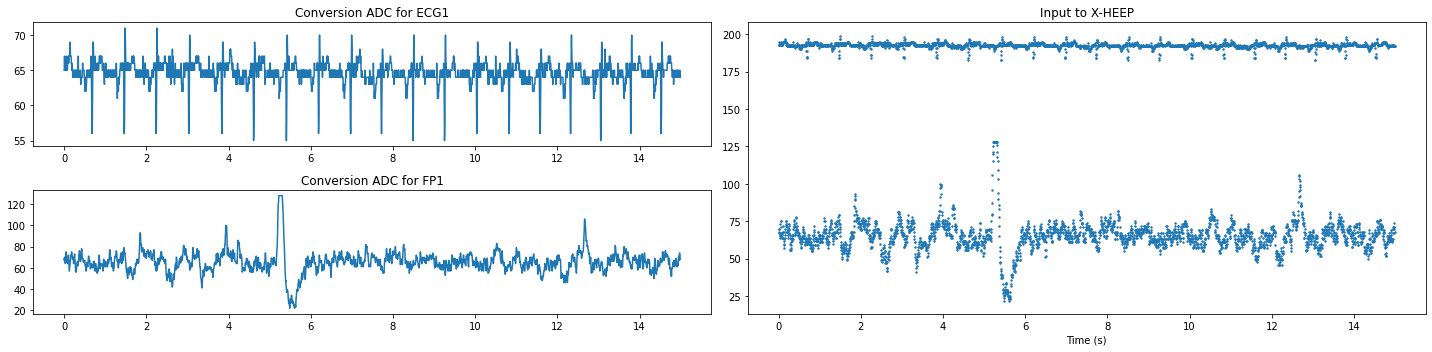

In [8]:
fig = plt.figure(figsize=(20,5))
indexes = [titles.index(element) for element in channels_to_plot]
channel_count = len(indexes)

# Create a Multi-Channel (MC) ADC
mcadc = mcADC("MultiChannel ADC", channels = [] )

# For each of the selected input channels create an emulated ADC
for ch_idx, ch_count in zip(indexes, range(len(indexes))):
    # Each ADC can have its own parameters, but in this example we use all of them with the same characteristics
    mcadc.channels.append( ADC( name        = f"ADC for {titles[ch_idx]}",  # Name of the channel
                                units       = "uV",                         # Units (for printing only)
                                f_sample_Hz = f_input_Hz,                   # Desired output frequency
                                ampl_bits   = ADC_RESOLUTION_BITS,          # Desired output resolution
                                dynRange    = [-1500, 1500],                # Dynamic range, in the input units.
                                series      =  Timeseries(  f"{titles[ch_idx]}",        # The Timeseries that is fed to the ADC
                                                            channels[ch_idx],           # The channel that will provide the values to this Timeseries
                                                            length_s = SIGNAL_LENGTH_S  # The length of the signal in seconds. Alternativelly we could have provided
                                                                                        # a sampling frequency or an array with timestamps.
                                                        )
                            )
                        )
    # Plot the output of each ADC channel
    ax = plt.subplot2grid((channel_count, 2), (channel_count - ch_count -1, 0), rowspan = 1 )
    ax.plot(mcadc.channels[ch_count].conversion.time, mcadc.channels[ch_count].conversion.data )
    ax.set_title(mcadc.channels[ch_count].conversion.name)

# Time-division-multiplex (TDM) the different channels of the MCADC. This will take one sample from each channel at a time and append them together.
mcadc.TDM()

# Plot the output of the MCADC
ax = plt.subplot2grid((channel_count, 2), (0, 1), rowspan = channel_count )
ax.set_title(mcadc.conversion.name)
ax.scatter(mcadc.conversion.time, mcadc.conversion.data, s=2  )
plt.title("Input to X-HEEP")
plt.xlabel("Time (s)")
plt.tight_layout()

### Export the output of the MCADC to a binary file to be used by the vADC 

In [9]:
# Export the output of the MCADC. These are the values that will be fed to the virtual ADC
mcadc.conversion.export_bin( outfile = DATA_FILE_NAME, bytes = ADC_WORD_SIZE_BYTES, bigendian = False )

# Check how many samples are actually sent (as this depend on the encoding chosen)
VADC_ACQUISITION_SAMPLES = len(mcadc.conversion.data)
print(f"Set {VADC_ACQUISITION_SAMPLES} words as input")

Set 5998 words as input


## Share information with the C code

A `definitions.h` file is created to share data between this notebook and the C code. You can add any kind of `#define` (including macros) to the code. 
In this case it is used to share strings that will be used by the software to parse a result and print it so we can extract it from the UART to plot it.  
We also share vADC sampling information to be used in configuring the acquisition.

In [10]:
# Write the definitions header file to share information with the C code
defs = Definitions( APP_PATH + 'definitions.h', "DEFINITIONS" )
defs.add( "VADC_ACQUISITION_SAMPLES",          VADC_ACQUISITION_SAMPLES )
defs.add( "X_HEEP_SAMPLING_BUFFER_SAMPLES",    X_HEEP_SAMPLING_BUFFER_SAMPLES )
defs.add( "WORD_SIZE_BYTES",                   ADC_WORD_SIZE_BYTES )
defs.add( "WORD_SIZE_BITS",                    ADC_WORD_SIZE_BITS )
defs.add( "ADC_CH_DATA_MASK",                  ADC_CH_DATA_MASK )
defs.add( "VADC_SAMPLING_FREQ_HZ",             FREQ_VADC_EMULATED_HZ )
defs.add( "ENABLE_PRINTF",                     1) # This is not the same as VERBOSE, as a) it actually reflects in C-code and therefore in performance and b) Will not allow to read the output to plot in this notebook
defs.close()

# Load the bitstream into the programmable logic

The bitstream of X-HEEP + the necessary peripherals to interact with the FEMU (`x_heep.bit`) are loaded. It should be located in `~/x-heep-femu-sdk/hw/` (w.r.t. this notebook: `../../../../hw/`). 

In [11]:
xh = x_heep()

✅ Bitstream loaded


# Compile the code and run the application

The C code written for X-HEEP in `~/x-heep-femu-sdk/sw/riscv/apps/adc-emu/adc-emu.c` will be compiled to generate the `code.*` files in `~/x-heep-femu-sdk/sw/build/`. This will be later loaded into X-HEEP for it to execute. 

After compilation, the `virtual ADC` is initialized with the signal that will be fed.

The performance counters are initialized (reset and started). These will capture the execution of X-HEEP and will be used to asses the latency of the execution and average power of each block of X-HEEP. 

During the exeuction the UART output will be printed live (unless `verbose` is set to `False`). 

The execution of this cells takes around 9 seconds (until compilation) + around 6 seconds for the program to start.

In [12]:
xh.compile_app("vadc_example")

vadc    = vADC(DATA_FILE_NAME)
perfc   = PerfCounters()

xh.run_app(verbose = True, perfCounters = perfc);

✅ Compile SUCCESS
Sampling frequency: 666666 Hz
Fast dma IRQ triggered!



KeyboardInterrupt



### Parse the UART output

Until now most steps were significantly _"application-agnostic"_. The parsing of the output will strongly depend on what you are trying to extract from X-HEEP.

In [ ]:
# Extract the UART output from X-HEEP
app_out = xh.uart_data
output_array = np.array([int(item) for item in app_out[app_out.index("Output\n") + 1:app_out.index("End\n")] if item.strip().isdigit()])

output = Timeseries("Output from X-HEEP", data=output_array, f_Hz = 666666/X_HEEP_SAMPLING_BUFFER_SAMPLES )

data_a = []
data_b = []
for d in output.data:
    data_a.append(d & 0x00003FFF)
    data_b.append((d & 0x3FFF0000) >> 16)

# Generate a time reference based on the input signal.
step = max(mcadc.conversion.time)/int(VADC_ACQUISITION_SAMPLES/X_HEEP_SAMPLING_BUFFER_SAMPLES)
time = list(np.arange(step, max(mcadc.conversion.time) + step, step))

output_a = Timeseries("Output A", data = data_a, time = time)
output_b = Timeseries("Output B", data = data_b, time = time)


## Plot the input and output

The obtained output will be plotted along with the input data `mcadc.conversion`. 

In [ ]:
import matplotlib.pyplot as plt

series = []
series.append(output_a)
series.append(mcadc.channels[0].conversion)
series.append(output_b)
series.append(mcadc.channels[1].conversion)

fig = plt.figure(figsize=(10,8))

ax = plt.subplot(2,1,1)
ax.plot(series[0].time, series[0].data)
ax.plot(series[1].time, series[1].data, alpha=0.3)
plt.legend([ s.name for s in series[:2] ], loc='lower right')

ax = plt.subplot(2,1,2)
ax.plot(series[2].time, series[2].data)
ax.plot(series[3].time, series[3].data, alpha=0.3)
plt.legend([ s.name for s in series[2:] ], loc='lower right')

plt.xlabel("Time (s)");


## Performance and Energy

During the execution of the application performance measurements were generated. In this section we will read them to generate latency and energy estimations. 

The report generated is stored in `~/x-heep-femu-sdk/sw/riscv/build/energy_estim.csv`.

Latency, power and energy results will be computed and can be compared to some defined budgets. 

You can prune your design by removing modules to estimate the power consumption of X-HEEP without these blocks. 

In [ ]:
from copy import deepcopy as cp
import pprint
from report import *

# Define some budgets that we should not cross
POWER_BUDGET_W      = 300e-6
LATENCY_BUDGET_S    = 100e-3

perfc.read_perf_cnt();                          # Read the performance counters
perfc.estimate_performance(verbose=False);      # Estimate the performance
perfc.estimate_energy("HVT", verbose=False);    # Estimate the energy using the HVT model

print("---------------------")
print("  Full System  ")
rep_summary, rep_latency, rep_energy  = report() # Get the report

print("---------------------")
print("  System Pruning  ")


# Remove modules that will not be used in the design.
# In case you want to print the dictionaries containing the breakdown
if 0: pprint.pprint(rep_energy)
# Otherwise you can check the names in sdk/sw/riscv/build/energy_estim.csv
pruned_energy = cp(rep_energy)

# List the modules that were not used and should be excluded from the performance evaluation
modules_to_remove = ["debug ao", "uart ao", "spi ao", "spi flash ao", "gpio", "i2c", "timer" ]
for m in modules_to_remove: pruned_energy = remove_module(pruned_energy, m )

rep_summary['Energy_J'] = pruned_energy['Total']
rep_summary['Power_W']  = rep_summary['Energy_J']/rep_summary['Latency_s']

print(f"Latency:\t{rep_summary['Latency_s']*1e3:0.2f} ms")
print(f"Energy: \t{rep_summary['Energy_J']*1e6:0.2f} µJ")
print(f"Avg Pwr:\t{rep_summary['Power_W']*1e6:0.2f} µW")

print( "✅ Latency SUCCESS" if rep_summary['Latency_s'] < LATENCY_BUDGET_S  else "❌ Latency FAIL" )
print( "✅ Power SUCCESS"   if rep_summary['Power_W']   < POWER_BUDGET_W    else "❌ Power FAIL"   )

# Plot a breakdown of the energy consumption
plot_energy( pruned_energy, level=1 )